### Libraries

In [92]:
## Install all these libraries ##
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import when, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Initialize

In [93]:
def start(file):
    """
    Start a spark session and read the csv
    """

    # Configure Spark
    spark = SparkSession.builder \
        .appName("American-Airlines") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.driver.maxResultSize", "4g") \
        .config("spark.sql.shuffle.partitions", "10") \
        .getOrCreate()

    df_raw = spark.read.csv(file, header=True, inferSchema=True)

    return df_raw


### Visualize and undrestand the data

In [94]:
def analyze_delay_data(df):
    """
    Analyze flight delay patterns using PySpark functions
    """

    # Time-based analysis
    print("\nAverage Delays by Day of Week:")
    df.groupBy("DayOfWeek")\
      .agg(
          F.avg("ArrDelay").alias("avg_arrival_delay"),
          F.count("*").alias("flight_count")
      )\
      .orderBy("DayOfWeek")\
      .show()

    print("\nAverage Delays by Month:")
    df.groupBy("Month")\
      .agg(
          F.avg("ArrDelay").alias("avg_arrival_delay"),
          F.count("*").alias("flight_count")
      )\
      .orderBy("Month")\
      .show()

    # Delay type analysis
    delay_cols = ["CarrierDelay", "WeatherDelay", "NASDelay",
                 "SecurityDelay", "LateAircraftDelay"]

    delay_stats = df.select([
        F.avg(col).alias(f"avg_{col}") for col in delay_cols
    ]).collect()[0]

    # Visualize delay types
    plt.figure(figsize=(10, 6))
    delays = [delay_stats[f"avg_{col}"] for col in delay_cols]
    plt.bar(delay_cols, delays)
    plt.xticks(rotation=45)
    plt.title("Average Minutes by Delay Type")
    plt.ylabel("Minutes")
    plt.tight_layout()
    plt.show()

    # Carrier analysis
    print("\nDelay Statistics by Carrier:")
    df.groupBy("UniqueCarrier")\
      .agg(
          F.avg("ArrDelay").alias("avg_arrival_delay"),
          F.count("*").alias("flight_count"),
          F.avg("Distance").alias("avg_distance")
      )\
      .orderBy(F.desc("flight_count"))\
      .show()

    # Route analysis
    print("\nTop 10 Routes with Highest Average Delays:")
    (df.groupBy("Origin", "Dest")
       .agg(
           F.avg("ArrDelay").alias("avg_delay"),
           F.count("*").alias("flight_count"),
           F.avg("Distance").alias("distance")
       )
       .filter(F.col("flight_count") > 100)
       .orderBy(F.desc("avg_delay"))
       .show(10)
    )

In [95]:
def analyze_delay_factors(df):
    """
    Analyze factors contributing to delays
    """

    # Distance vs Delay relationship
    distance_delay = df.select(
        F.corr("Distance", "ArrDelay").alias("distance_delay_correlation")
    ).collect()[0]

    print("\nCorrelation between Distance and Arrival Delay:",
          distance_delay["distance_delay_correlation"])

    # Ground operations impact
    ground_stats = df.select(
        F.corr("TaxiIn", "ArrDelay").alias("taxiin_correlation"),
        F.corr("TaxiOut", "ArrDelay").alias("taxiout_correlation")
    ).collect()[0]

    print("\nGround Operations Correlations:")
    print(f"TaxiIn - Arrival Delay: {ground_stats['taxiin_correlation']:.3f}")
    print(f"TaxiOut - Arrival Delay: {ground_stats['taxiout_correlation']:.3f}")


### Preprocess

In [96]:
def preprocess(df_raw):
    """
    Preprocess the raw data
    """

    df = df_raw.drop("Year", "TailNum", "TailNum", "DayOfMonth", "FlightNum", "DepTime", "CRSDepTime", "CRSArrTime", "Month", "DayOfWeek", "UniqueCarrier","Dest", "Origin", "CancellationCode", "Diverted")

    df = df.filter(df.Cancelled != 1)
    df = df.filter(
        (df.ArrTime != "NA") &
        (df.ActualElapsedTime != "NA") &
        (df.CRSElapsedTime != "NA") &
        (df.ArrDelay != "NA") &
        (df.TaxiIn != "NA")
    )

    columns_to_check = ["WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "CarrierDelay"]

    # Loop through columns and replace "NA" with 0
    for column in columns_to_check:
        df = df.withColumn(
            column,
            when(col(column) == "NA", 0).otherwise(col(column))
        )

    all_columns = df.columns

    # Cast to float
    for column in  all_columns:
        df = df.withColumn(column, F.col(column).cast("float"))

    # Create a new column for TotalDelay by summing delay related columns
    df = df.withColumn(
        "TotalDelay",
        F.coalesce(F.col("ArrDelay"), F.lit(0)) +
        F.coalesce(F.col("DepDelay"), F.lit(0)) +
        F.coalesce(F.col("CarrierDelay"), F.lit(0)) +
        F.coalesce(F.col("WeatherDelay"), F.lit(0)) +
        F.coalesce(F.col("NASDelay"), F.lit(0)) +
        F.coalesce(F.col("SecurityDelay"), F.lit(0)) +
        F.coalesce(F.col("LateAircraftDelay"), F.lit(0))
    )

    return df

### Split and make features column

In [97]:
def split(df):
    """
    Split the data into train and test, also make a feature vector
    """
    train_df, test_df = df.randomSplit([0.8, 0.2], seed=1234)

    feature_columns = ["DepDelay", "Distance", "TaxiIn", "TaxiOut", "CarrierDelay", "WeatherDelay"]

    # Create the Vector Assembler
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    # Prepare the data by transforming the train and test datasets
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)

    return train_df, test_df, feature_columns

### Initialize, train and predict

In [98]:
def linearregression(train_df, test_df):
    """
    Linear Regression with cross-validation for parameter tuning
    """

    # Initialize the Linear Regression model
    lr = LinearRegression(
        featuresCol="features",
        labelCol="TotalDelay"
    )

    # Create parameter grid
    paramGrid = ParamGridBuilder()\
        .addGrid(lr.regParam, [0.01, 0.1, 1.0])\
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
        .build()

    # Create evaluator
    evaluator = RegressionEvaluator(
        labelCol="TotalDelay",
        predictionCol="prediction",
        metricName="rmse"
    )

    # Create CV
    cv = CrossValidator(
        estimator=lr,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=3
    )

    # Fit CrossValidator to find best model
    cv_model = cv.fit(train_df)

    # Get best model
    best_model = cv_model.bestModel

    # Make predictions using best model
    predictions = best_model.transform(test_df)

    # Print best parameters
    print("\nBest Model Parameters:")
    print(f"RegParam: {best_model._java_obj.getRegParam()}")
    print(f"ElasticNetParam: {best_model._java_obj.getElasticNetParam()}")

    return predictions, best_model


### Evaluate

In [99]:
def evaluate(predictions, lr_model, feature_columns):
    """
    Perform detailed evaluation of the model including visualizations
    """

    # Convert predictions to pandas for visualization
    pred_pd = predictions.select("TotalDelay", "prediction").toPandas()

    # Basic Metrics
    evaluator = RegressionEvaluator(labelCol="TotalDelay", predictionCol="prediction")
    metrics = {
        "RMSE": evaluator.evaluate(predictions, {evaluator.metricName: "rmse"}),
        "MAE": evaluator.evaluate(predictions, {evaluator.metricName: "mae"}),
        "R2": evaluator.evaluate(predictions, {evaluator.metricName: "r2"}),
        "MSE": evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
    }

    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Feature Importance
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': lr_model.coefficients
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance)

    plt.figure(figsize=(15, 10))

    # Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(pred_pd['TotalDelay'], pred_pd['prediction'], alpha=0.5)
    plt.plot([pred_pd['TotalDelay'].min(), pred_pd['TotalDelay'].max()],
             [pred_pd['TotalDelay'].min(), pred_pd['TotalDelay'].max()],
             'r--', lw=2)
    plt.xlabel('Actual Delay')
    plt.ylabel('Predicted Delay')
    plt.title('Actual vs Predicted Delay')

    # Residual Plot
    plt.subplot(2, 2, 2)
    residuals = pred_pd['TotalDelay'] - pred_pd['prediction']
    plt.scatter(pred_pd['prediction'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Delay')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # Feature Importance Plot
    plt.subplot(2, 2, 3)
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')

    # Residual Distribution
    plt.subplot(2, 2, 4)
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residual Value')
    plt.ylabel('Count')
    plt.title('Residual Distribution')

    plt.tight_layout()
    plt.show()

    print("\nError Analysis:")
    print(f"Mean Residual: {residuals.mean():.2f}")
    print(f"Residual Std: {residuals.std():.2f}")

    percentiles = np.percentile(abs(residuals), [25, 50, 75, 90, 95, 99])
    print("\nError Percentiles (absolute):")
    print(f"25th percentile: {percentiles[0]:.2f}")
    print(f"50th percentile: {percentiles[1]:.2f}")
    print(f"75th percentile: {percentiles[2]:.2f}")
    print(f"90th percentile: {percentiles[3]:.2f}")
    print(f"95th percentile: {percentiles[4]:.2f}")
    print(f"99th percentile: {percentiles[5]:.2f}")

   # Performance at Different Delay Ranges
    pred_pd['abs_error'] = abs(residuals)
    pred_pd['delay_range'] = pd.qcut(pred_pd['TotalDelay'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    range_performance = pred_pd.groupby('delay_range', observed=True).agg({
        'abs_error': ['mean', 'std', 'count']
    }).round(2)

    print("\nPerformance by Delay Range:")
    print(range_performance)

    return metrics


### Main

Analyzing delay patterns in raw data...

Average Delays by Day of Week:


+---------+------------------+------------+
|DayOfWeek| avg_arrival_delay|flight_count|
+---------+------------------+------------+
|        1| 8.210850494863875|     1036201|
|        2| 7.481207604036612|     1032049|
|        3| 6.522017315719349|     1039665|
|        4|  8.41159915807781|     1032224|
|        5|10.953440079613667|     1035166|
|        6| 5.789666410427927|      857536|
|        7| 9.495886006775251|      976887|
+---------+------------------+------------+


Average Delays by Month:


+-----+------------------+------------+
|Month| avg_arrival_delay|flight_count|
+-----+------------------+------------+
|    1|10.188855960349496|      605765|
|    2|13.077836997760205|      569236|
|    3| 11.19236458018227|      616090|
|    4| 6.807297481094145|      598126|
|    5| 5.978448290248828|      606293|
|    6|13.266756009659792|      608665|
|    7| 9.975049681276131|      627931|
|    8|  6.91091468997087|      612279|
|    9|0.6977328787273043|      540908|
|   10|0.4154954706912698|      556205|
|   11| 2.015857969430839|      523272|
|   12|16.680505081496417|      544958|
+-----+------------------+------------+



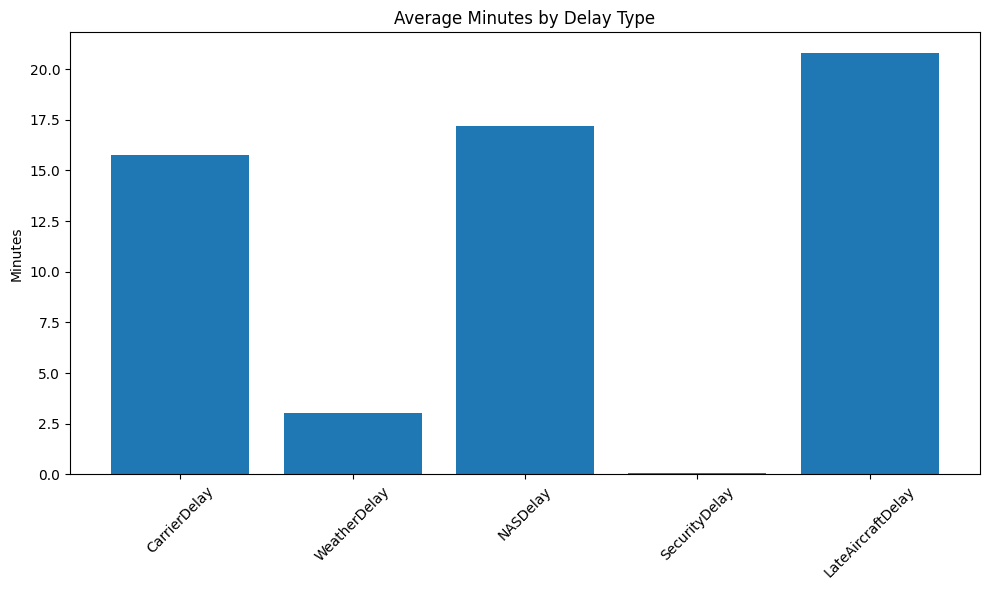


Delay Statistics by Carrier:


+-------------+------------------+------------+------------------+
|UniqueCarrier| avg_arrival_delay|flight_count|      avg_distance|
+-------------+------------------+------------+------------------+
|           WN|  5.17967817300539|     1201754| 635.1615180810714|
|           AA|12.607194035713981|      604885| 1053.208211478215|
|           OO| 6.598884736868734|      567159| 429.4147091027384|
|           MQ| 9.890667945776498|      490693| 410.8336638183141|
|           US|2.8481100056939694|      453589|  855.894964384057|
|           DL| 7.855163154883384|      451931| 921.5494290057553|
|           UA|11.291322186680183|      449515|1078.4640379075227|
|           XE|10.635404800035221|      374510| 589.1859896931991|
|           NW| 7.368539129929383|      347652| 803.7812122467295|
|           CO|  10.9790372802913|      298455|  1153.27608182138|
|           EV|10.208002415713782|      280575|443.86916867147823|
|           9E| 4.111134703250211|      262208|450.66812606785

+------+----+------------------+------------+--------+
|Origin|Dest|         avg_delay|flight_count|distance|
+------+----+------------------+------------+--------+
|   GUC| DFW| 61.48543689320388|         111|   678.0|
|   HDN| ORD| 55.69109947643979|         205|  1009.0|
|   EWR| ABQ| 52.68292682926829|         166|  1805.0|
|   MKE| SFO| 50.03603603603604|         115|  1845.0|
|   EGE| LAX|45.574074074074076|         111|   748.0|
|   ASE| ORD| 44.85865724381625|         332|  1013.0|
|   FCA| ORD| 44.16346153846154|         104|  1352.0|
|   EWR| LIT|43.954692556634306|         323|  1069.0|
|   LAX| EGE|40.283018867924525|         107|   748.0|
|   DFW| GUC| 40.20388349514563|         109|   678.0|
+------+----+------------------+------------+--------+
only showing top 10 rows


Analyzing delay factors...



Correlation between Distance and Arrival Delay: 0.00655090543236988



Ground Operations Correlations:
TaxiIn - Arrival Delay: 0.123
TaxiOut - Arrival Delay: 0.322



Best Model Parameters:
RegParam: 0.01
ElasticNetParam: 0.0



Model Performance Metrics:
RMSE: 17.4518
MAE: 11.8810
R2: 0.9739
MSE: 304.5652

Feature Importance:
        Feature  Importance
0      DepDelay    2.884963
3       TaxiOut    1.405543
2        TaxiIn    1.266756
5  WeatherDelay    0.152488
4  CarrierDelay    0.097908
1      Distance   -0.004757


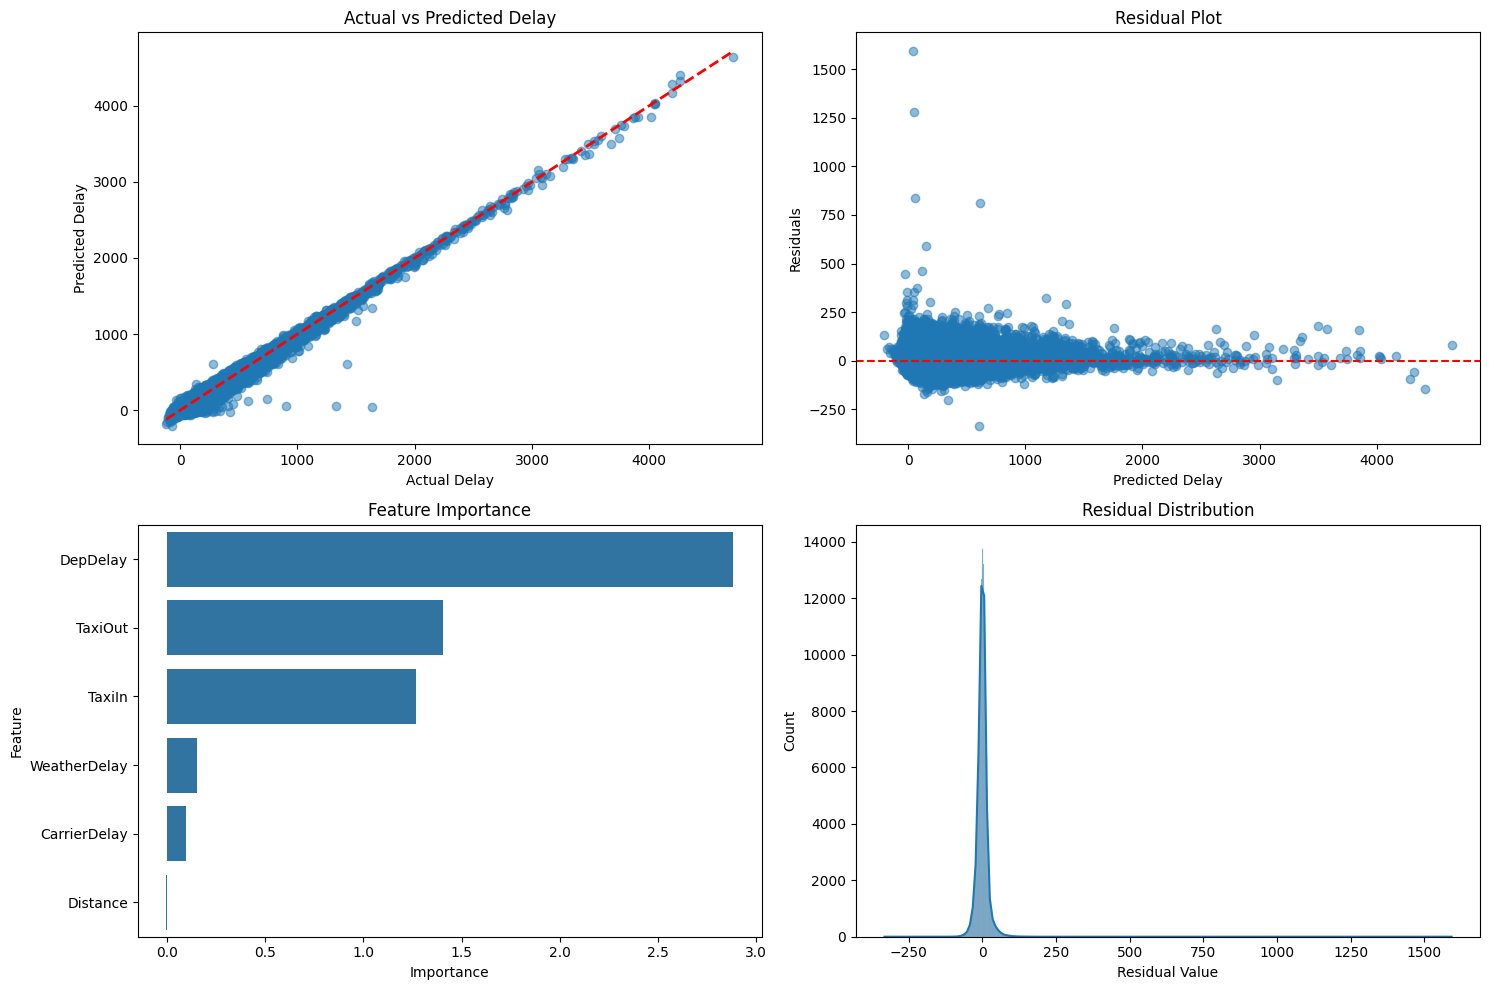


Error Analysis:
Mean Residual: 0.03
Residual Std: 17.45

Error Percentiles (absolute):
25th percentile: 3.87
50th percentile: 8.39
75th percentile: 15.36
90th percentile: 25.74
95th percentile: 35.31
99th percentile: 61.03

Performance by Delay Range:
            abs_error               
                 mean    std   count
delay_range                         
Very Low         8.95   8.20  288461
Low              8.01   6.85  290935
Medium           8.93   7.61  262278
High            14.45  12.20  256539
Very High       19.53  20.16  272925


In [100]:
df_raw = start("../Dataset/2008.csv") ## DOWNLOAD THE DATASET: https://www.kaggle.com/datasets/artomas/us-flights/data

print("Analyzing delay patterns in raw data...")
analyze_delay_data(df_raw)

print("\nAnalyzing delay factors...")
analyze_delay_factors(df_raw)

df = preprocess(df_raw)

train_df, test_df, feature_columns = split(df)

predictions, lr_model = linearregression(train_df, test_df)

metrics = evaluate(predictions, lr_model, feature_columns)
